# Generative Adversarial Networks
So far, all the models we have worked with except the VAE have been discriminative models. This means that they are simply trying to predit something about our existing dataset. Sometimes, we would not like to discriminate but generate new examples of the data as in the case of video or image generation.

Technically, this is the problem of modelling a probability distribution which we have examples of. There are many models which try to explicitly model this distribution such as VAEs

One approach which implicitly models the distribution, the work of Ian Goodfellow, has be enjoying great success - often producing images indistinguishable from the examples on which it was trained. GANs take a game-theoretic approach, pitting two networks against eachother - the discriminator and the generator. The job of the generator is to produce images which are indistinguishable from the training set from latent variables while the job of the discriminator is to catch out the generator and discriminate real data from generated data. Initially they will both be terrible at their jobs but as the discriminator gets better, the generator is forced to get better to fool it and vice-versa. This loop continues until they are both excellent at their jobs and the generator can now be used to produce very realistic data points.

An analogy often used to describe this is the detective and the forger. The generator is like a forger who is trying to produce paintings indistinguishable from other famous paintings by an artists while the discriminator is like a detective who is trying to catch the forger out. As the detective gets better at catching the generator out, the generator is forced to improve to fool the detective.
- generate: generate random samples from the data 
- discriminator: detect generated samples 

## Implementation
We will be training a GAN on the fashion MNIST dataset so we will be able to produce images of items of clothing which look like they came from the original dataset.

We begin by importing the appropriate libraries.

need to add .cuda() to all the variables or as they are put forward to make sure that they run through the GPU version (after defined variables and foward)

In [0]:
%matplotlib inline
#matplotlib notebook --> inline works better with colab
import torch
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt    

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

We load our dataset into a pytorch dataloader which we will use later to produce random batches of samples from our dataset.

In [4]:
batch_size = 100 #need to be divisible by 60K

#60K training examples and 10K training examples 

train_data = datasets.FashionMNIST(root='fashiondata/',
                                 transform=transforms.ToTensor(),
                                 train=True,
                                 download=True
                                 )
#load dataset into dataloader to sample from data 
train_samples = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True
                                            )

Processing...
Done!


Define the NN model we will be using for our discriminator. It takes in the 28x28 image and performs convolutions followed by one fully connected layer to output the probability of the data point being real and not generated.
- need to make 2 neural networks: discriminator + generator 
- discriminator: 2 convolutional layers with 1 fully connected layer 
- 64 filter, with 14x14 image --> down sampling by 0.5 
- decrease the size of 2D image by 0.5 again with self.conv2 

In [0]:
class discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1) #1x28x28-> 64x14x14
        #padding = design choice ??
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) #64x14x14-> 128x7x7
        
        self.dense1 = torch.nn.Linear(128*7*7, 1) #make into 1 long vector 
        #128*7*7 --> # of neurons 
        
        # define batch norms to convolutions to increase performances 
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.bn2 = torch.nn.BatchNorm2d(128)
        
    #apply the batch norms sequentially 
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x))).view(-1, 128*7*7) #change size --> make output 128*7*7
        #fixed number of columns and indeterminate # of rows 
        #sigmoid: predict a probability f it being a real data point 
        x = F.sigmoid(self.dense1(x))
        return x

Define the NN model for the generator. This takes in a latent vector of size 128 and performs fully connected layers followed by upconvolution to output us a 28x28 image.
- up convolution: take low dimension thing & go in reverse to make it larger 
- similar process, but in reverse 

In [0]:
#since the discriminator's task is easier, need to equalize 
#give generator more capacity --> more equal power will evolve faster 

class generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(128, 256) #feed in 128 vectors, 
        #256 = fully connected layer 
        self.dense2 = torch.nn.Linear(256, 1024)
        self.dense3 = torch.nn.Linear(1024, 128*7*7)
        #128*7*7 --> reshaped into a 3D volume 
        #up sample from 3D value 
        self.uconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) #128x7x7 -> 64x14x14
        #ConvTranspose2d reverse of the previous class 
        self.uconv2 = torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1) #64x14x14 -> 1x28x28
        #doubles dimesions: go from 64 filter to 1 filter + 28c 28 
        
        #batch norm is very important in this case 
        # 3 layer output: image instead of layer 
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.bn2 = torch.nn.BatchNorm1d(1024)
        self.bn3 = torch.nn.BatchNorm1d(128*7*7)
        self.bn4 = torch.nn.BatchNorm2d(64)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.dense1(x)))
        x = F.relu(self.bn2(self.dense2(x)))
        x = F.relu(self.bn3(self.dense3(x))).view(-1, 128, 7, 7) #-1 to fit whatever # of trainings generated into desired format 
        x = F.relu(self.bn4(self.uconv1(x)))
        x = F.sigmoid(self.uconv2(x)) #value has to be b/w 0 and 1 
        return x

We instantiate our models from the classes we define and their optimizers

In [8]:
#instantiate model
d = discriminator().cuda()
g = generator().cuda()

#training hyperparameters
no_epochs = 100
dlr = 0.0003
glr = 0.0003

d_optimizer = torch.optim.Adam(d.parameters(), lr=dlr)
g_optimizer = torch.optim.Adam(g.parameters(), lr=glr)

dcosts = []
gcosts = []
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
ax.set_xlim(0, no_epochs)
plt.show()

<IPython.core.display.Javascript object>

We define the training loop. For every batch of training data that we look at, we get the generator to produce an equally sized batch of generated images. We then get the discriminator to make predictions on both sets and calulate the cost for both networks before calculating the gradients and training each one in turn.

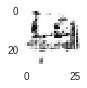

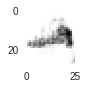

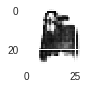

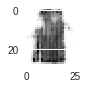

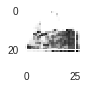

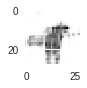

Epoch:  0
Disciminator cost:  0.0005232114942414188
Generator cost:  0.004708557106267532


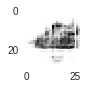

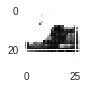

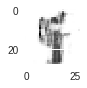

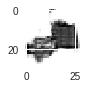

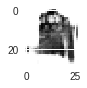

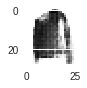

Epoch:  1
Disciminator cost:  0.0006695866759395116
Generator cost:  0.004278887233554081


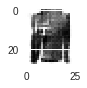

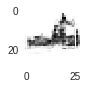

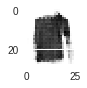

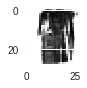

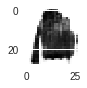

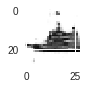

Epoch:  2
Disciminator cost:  0.000442164531063687
Generator cost:  0.004324590083600999


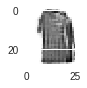

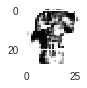

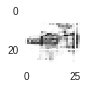

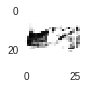

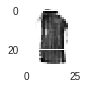

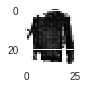

Epoch:  3
Disciminator cost:  0.0006945380151929125
Generator cost:  0.003811430261328237


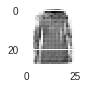

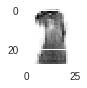

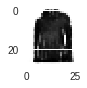

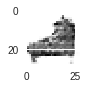

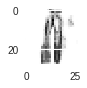

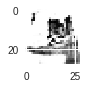

Epoch:  4
Disciminator cost:  0.0021430938968050703
Generator cost:  0.0021628715111599844


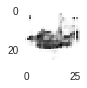

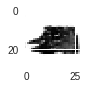

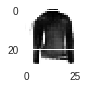

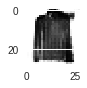

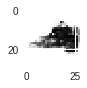

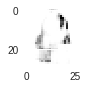

Epoch:  5
Disciminator cost:  0.001226107654425857
Generator cost:  0.0034764603546946237


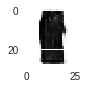

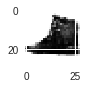

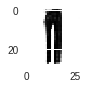

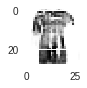

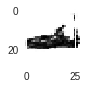

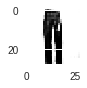

Epoch:  6
Disciminator cost:  0.0019287277482883298
Generator cost:  0.0024447459874373293


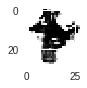

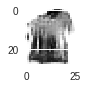

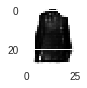

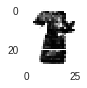

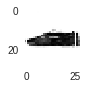

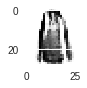

Epoch:  7
Disciminator cost:  0.002345888183552647
Generator cost:  0.003012135507521621


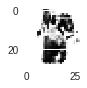

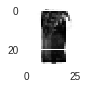

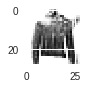

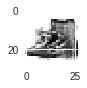

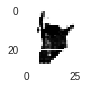

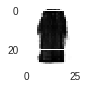

Epoch:  8
Disciminator cost:  0.001525911812925719
Generator cost:  0.0021513843522490625


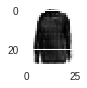

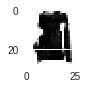

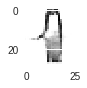

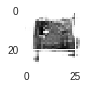

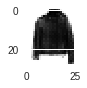

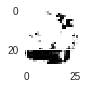

Epoch:  9
Disciminator cost:  0.0018225776491436385
Generator cost:  0.002873145983193756


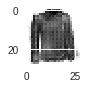

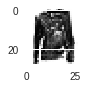

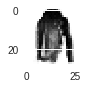

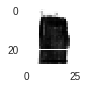

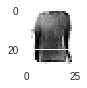

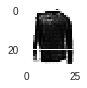

Epoch:  10
Disciminator cost:  0.0016750054247051216
Generator cost:  0.002525076682983779


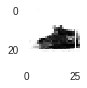

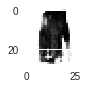

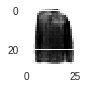

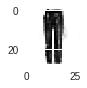

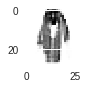

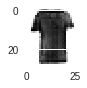

Epoch:  11
Disciminator cost:  0.0013538435409683942
Generator cost:  0.0023735822788851298


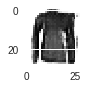

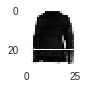

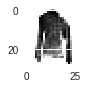

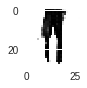

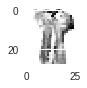

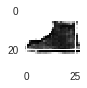

Epoch:  12
Disciminator cost:  0.0017998262009797498
Generator cost:  0.001974887347753499


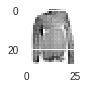

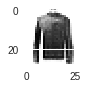

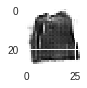

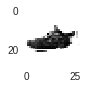

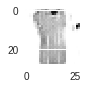

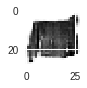

Epoch:  13
Disciminator cost:  0.0014516224523592415
Generator cost:  0.0025692374848388815


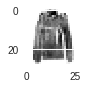

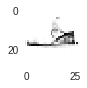

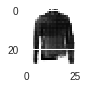

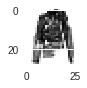

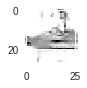

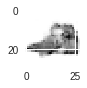

Epoch:  14
Disciminator cost:  0.0016540684245356628
Generator cost:  0.0019032448188508215


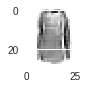

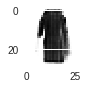

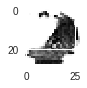

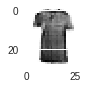

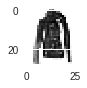

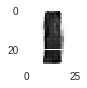

Epoch:  15
Disciminator cost:  0.0017675202910004731
Generator cost:  0.0017810248727672029


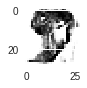

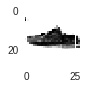

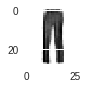

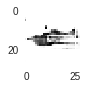

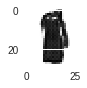

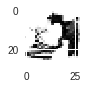

Epoch:  16
Disciminator cost:  0.001925140657759632
Generator cost:  0.0017168032282572742


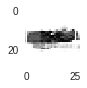

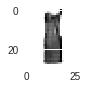

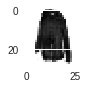

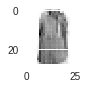

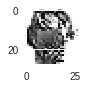

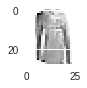

Epoch:  17
Disciminator cost:  0.002505762008454144
Generator cost:  0.0017395638652058516


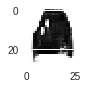

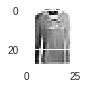

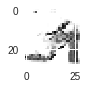

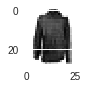

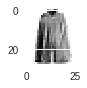

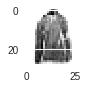

Epoch:  18
Disciminator cost:  0.0026064163337867
Generator cost:  0.0017314392932058073


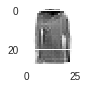

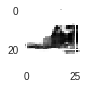

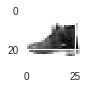

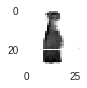

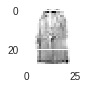

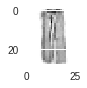

Epoch:  19
Disciminator cost:  0.0025021957293288348
Generator cost:  0.0012649554946355414


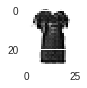

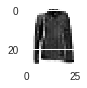

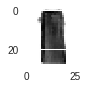

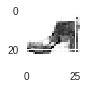

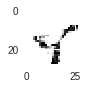

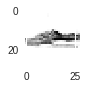

Epoch:  20
Disciminator cost:  0.0020535976725970127
Generator cost:  0.001344437003912254


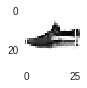

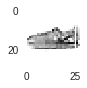

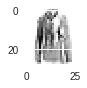

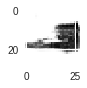

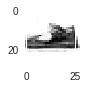

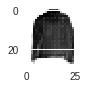

Epoch:  21
Disciminator cost:  0.0017599510543223026
Generator cost:  0.001786604686486385


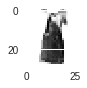

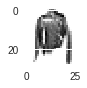

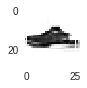

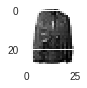

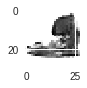

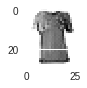

Epoch:  22
Disciminator cost:  0.0021479095865042817
Generator cost:  0.0015471654947685127


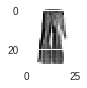

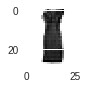

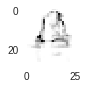

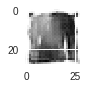

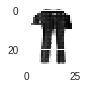

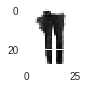

Epoch:  23
Disciminator cost:  0.0021249005658082096
Generator cost:  0.001490894615546726


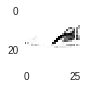

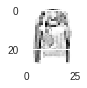

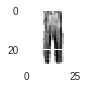

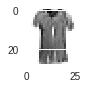

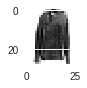

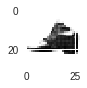

Epoch:  24
Disciminator cost:  0.0021397621214753896
Generator cost:  0.0015704938839769945


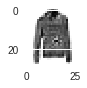

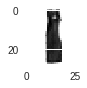

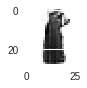

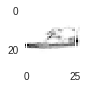

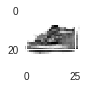

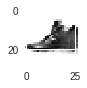

Epoch:  25
Disciminator cost:  0.0021839830749918257
Generator cost:  0.0014037531230814508


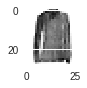

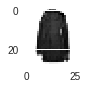

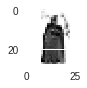

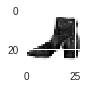

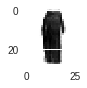

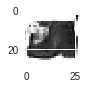

Epoch:  26
Disciminator cost:  0.001994997083936212
Generator cost:  0.0015160211749417978


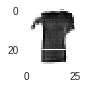

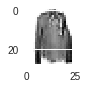

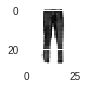

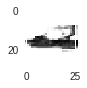

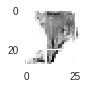

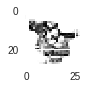

Epoch:  27
Disciminator cost:  0.0019930854193666767
Generator cost:  0.0017513594960481146


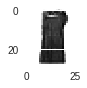

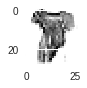

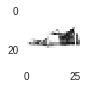

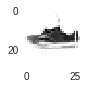

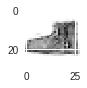

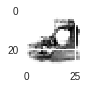

Epoch:  28
Disciminator cost:  0.002071617443112753
Generator cost:  0.001583191984096437


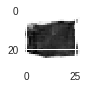

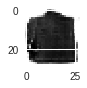

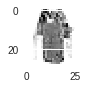

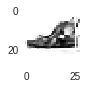

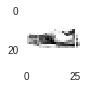

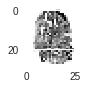

Epoch:  29
Disciminator cost:  0.0019711956950498005
Generator cost:  0.0017819545631033277


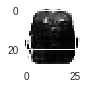

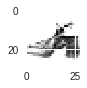

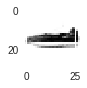

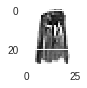

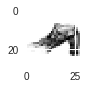

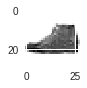

Epoch:  30
Disciminator cost:  0.0021433753386647762
Generator cost:  0.0013521343755636326


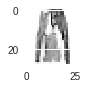

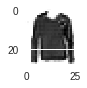

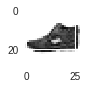

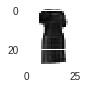

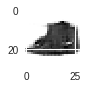

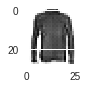

Epoch:  31
Disciminator cost:  0.002090197984857282
Generator cost:  0.0016580035509702223


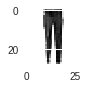

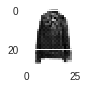

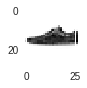

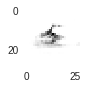

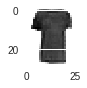

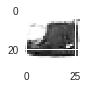

Epoch:  32
Disciminator cost:  0.002405498510833184
Generator cost:  0.0012422483544681493


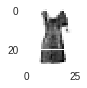

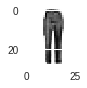

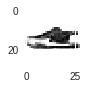

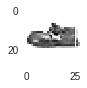

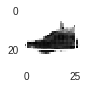

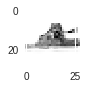

Epoch:  33
Disciminator cost:  0.0020609500261546737
Generator cost:  0.0017164277170639004


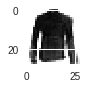

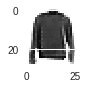

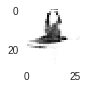

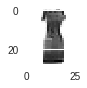

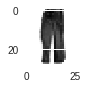

Epoch:  34
Disciminator cost:  0.0021464260420905644
Generator cost:  0.0017789295665241222


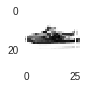

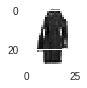

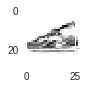

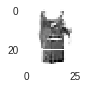

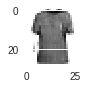

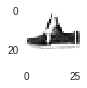

Epoch:  35
Disciminator cost:  0.0021454110977932083
Generator cost:  0.0014612023953013984


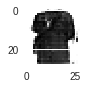

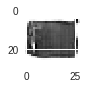

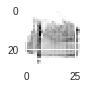

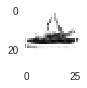

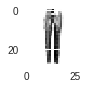

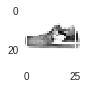

Epoch:  36
Disciminator cost:  0.0019726555992649712
Generator cost:  0.0013933813294982162


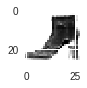

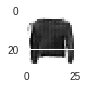

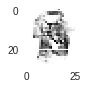

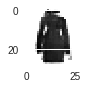

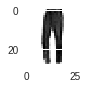

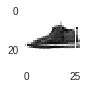

Epoch:  37
Disciminator cost:  0.0020334074830532967
Generator cost:  0.0014467491255249151


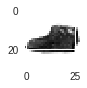

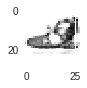

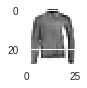

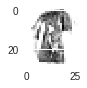

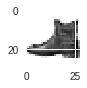

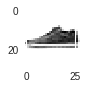

Epoch:  38
Disciminator cost:  0.0024701672382413625
Generator cost:  0.001267505500681478


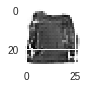

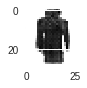

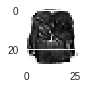

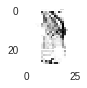

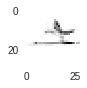

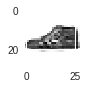

Epoch:  39
Disciminator cost:  0.002561142466325564
Generator cost:  0.0013158828491507382


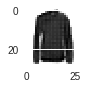

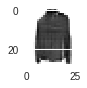

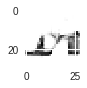

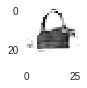

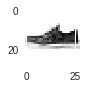

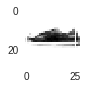

Epoch:  40
Disciminator cost:  0.0021046211900203867
Generator cost:  0.0016354151596323365


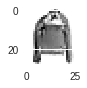

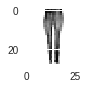

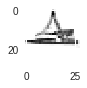

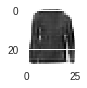

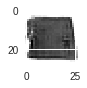

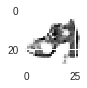

Epoch:  41
Disciminator cost:  0.0022647249848659233
Generator cost:  0.001353423344862426


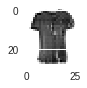

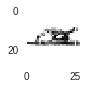

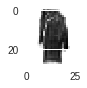

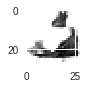

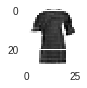

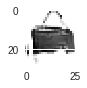

Epoch:  42
Disciminator cost:  0.0021290087185627652
Generator cost:  0.0014954811693899896


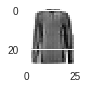

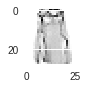

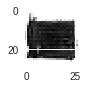

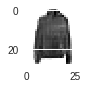

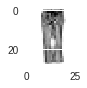

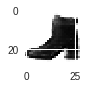

Epoch:  43
Disciminator cost:  0.0019109650729798274
Generator cost:  0.001557229619683291


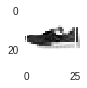

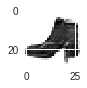

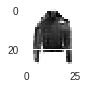

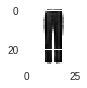

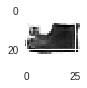

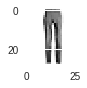

Epoch:  44
Disciminator cost:  0.0022329981530214895
Generator cost:  0.0016003507813642408


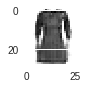

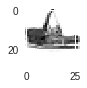

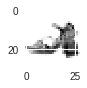

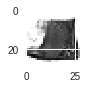

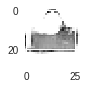

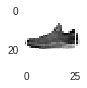

Epoch:  45
Disciminator cost:  0.0022008315871594702
Generator cost:  0.0013279604825787398


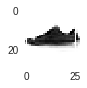

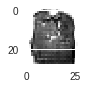

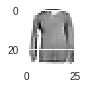

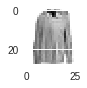

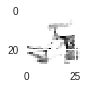

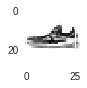

Epoch:  46
Disciminator cost:  0.0019335558294444673
Generator cost:  0.0015618354319930647


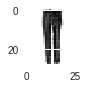

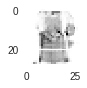

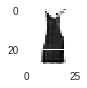

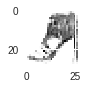

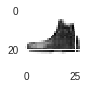

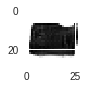

Epoch:  47
Disciminator cost:  0.0019521907004917335
Generator cost:  0.0014516834345218508


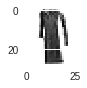

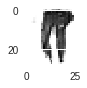

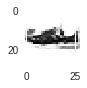

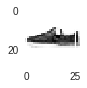

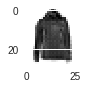

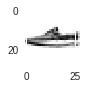

Epoch:  48
Disciminator cost:  0.0020624210501151196
Generator cost:  0.0015900837089047794


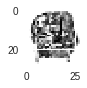

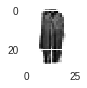

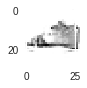

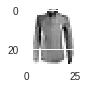

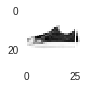

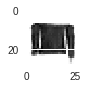

Epoch:  49
Disciminator cost:  0.0017276297770362121
Generator cost:  0.0014273564924172047


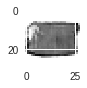

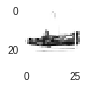

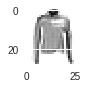

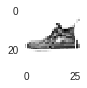

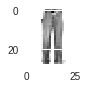

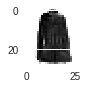

Epoch:  50
Disciminator cost:  0.0018582345736699072
Generator cost:  0.0018141907937719247


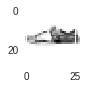

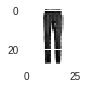

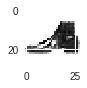

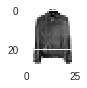

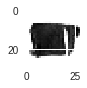

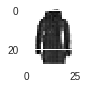

Epoch:  51
Disciminator cost:  0.0021845049279394296
Generator cost:  0.0013825441885620489


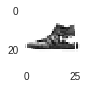

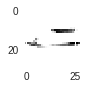

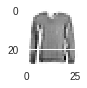

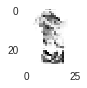

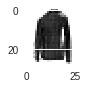

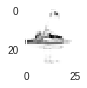

Epoch:  52
Disciminator cost:  0.0025459246630867953
Generator cost:  0.0014505520066411697


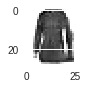

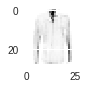

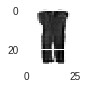

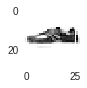

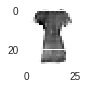

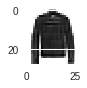

Epoch:  53
Disciminator cost:  0.002146165654519264
Generator cost:  0.0013898366766748858


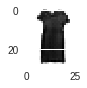

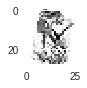

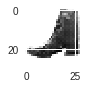

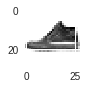

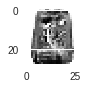

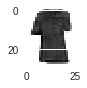

Epoch:  54
Disciminator cost:  0.0019119972830732243
Generator cost:  0.0013635748393971787


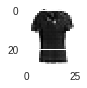

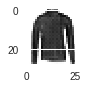

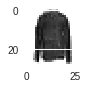

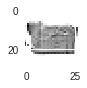

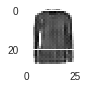

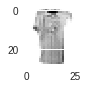

Epoch:  55
Disciminator cost:  0.0028407311746416683
Generator cost:  0.0013865832844694138


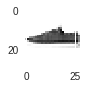

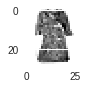

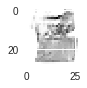

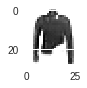

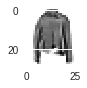

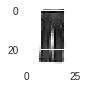

Epoch:  56
Disciminator cost:  0.0021656363871683216
Generator cost:  0.0013630270936914983


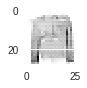

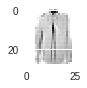

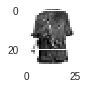

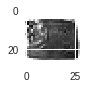

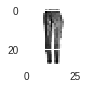

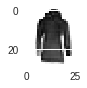

Epoch:  57
Disciminator cost:  0.002387291387442931
Generator cost:  0.0012718474682418192


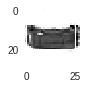

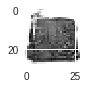

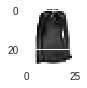

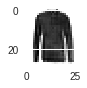

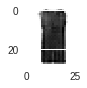

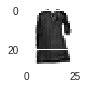

Epoch:  58
Disciminator cost:  0.002357730552057212
Generator cost:  0.0014761953065065892


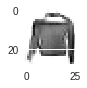

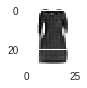

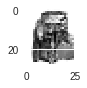

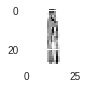

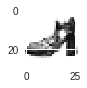

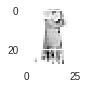

Epoch:  59
Disciminator cost:  0.0021871373446099964
Generator cost:  0.0013741841691163046


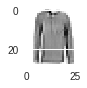

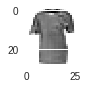

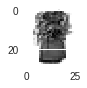

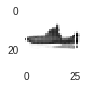

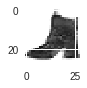

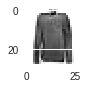

Epoch:  60
Disciminator cost:  0.002229808061547395
Generator cost:  0.0015935206657128583


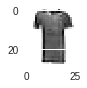

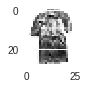

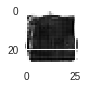

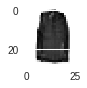

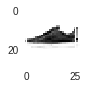

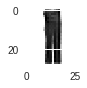

Epoch:  61
Disciminator cost:  0.0021214392125075074
Generator cost:  0.0015718212569757737


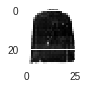

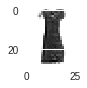

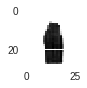

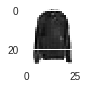

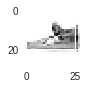

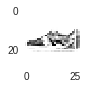

Epoch:  62
Disciminator cost:  0.0018771307194916183
Generator cost:  0.001560373684483089


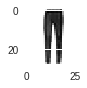

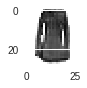

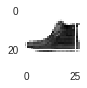

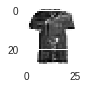

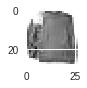

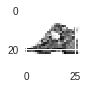

Epoch:  63
Disciminator cost:  0.002112606271369642
Generator cost:  0.0014334989197167726


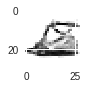

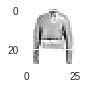

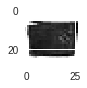

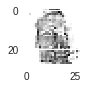

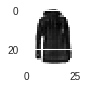

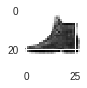

Epoch:  64
Disciminator cost:  0.002226270028258548
Generator cost:  0.0013402124107031875


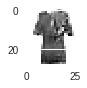

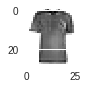

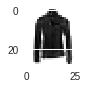

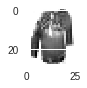

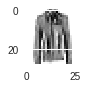

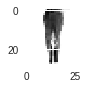

Epoch:  65
Disciminator cost:  0.002288371566772226
Generator cost:  0.001692555081005086


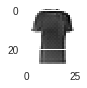

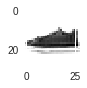

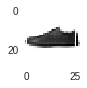

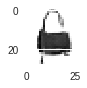

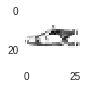

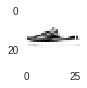

Epoch:  66
Disciminator cost:  0.002632420795281986
Generator cost:  0.0012274199958715844


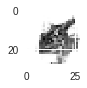

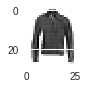

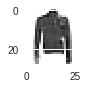

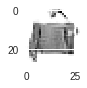

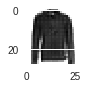

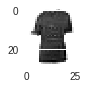

Epoch:  67
Disciminator cost:  0.001960287268819616
Generator cost:  0.0013895444217513402


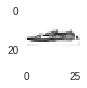

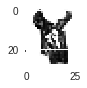

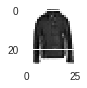

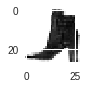

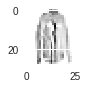

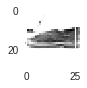

Epoch:  68
Disciminator cost:  0.0021777920343244803
Generator cost:  0.0014541941210513283


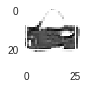

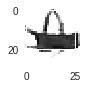

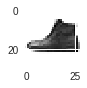

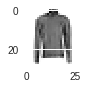

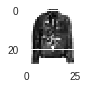

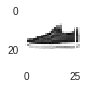

Epoch:  69
Disciminator cost:  0.002106355124069467
Generator cost:  0.0012594223839394478


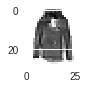

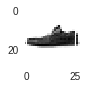

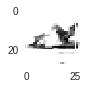

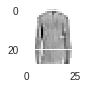

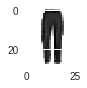

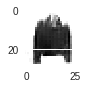

Epoch:  70
Disciminator cost:  0.0020728188760826324
Generator cost:  0.0012242249344155726


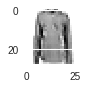

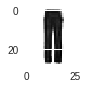

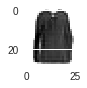

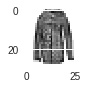

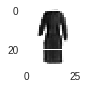

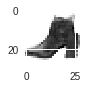

Epoch:  71
Disciminator cost:  0.002303192258891508
Generator cost:  0.0012360333215420004


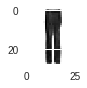

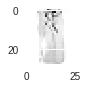

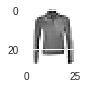

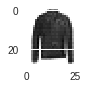

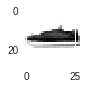

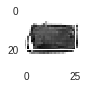

Epoch:  72
Disciminator cost:  0.0019885315339330752
Generator cost:  0.0014186608921299918


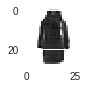

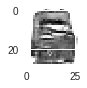

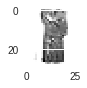

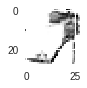

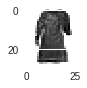

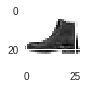

Epoch:  73
Disciminator cost:  0.0024983592944423038
Generator cost:  0.0012821567430668875


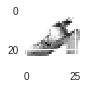

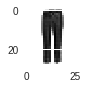

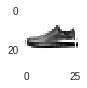

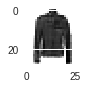

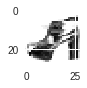

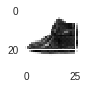

Epoch:  74
Disciminator cost:  0.0018696483120676662
Generator cost:  0.0013754141250252325


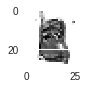

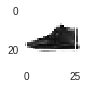

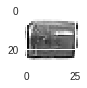

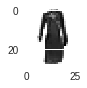

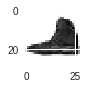

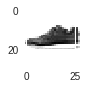

Epoch:  75
Disciminator cost:  0.0020927629562882103
Generator cost:  0.0013925425253700566


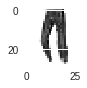

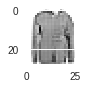

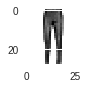

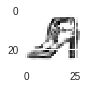

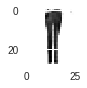

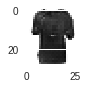

Epoch:  76
Disciminator cost:  0.0022486374268741905
Generator cost:  0.001346177245548266


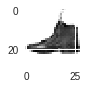

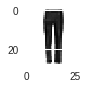

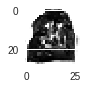

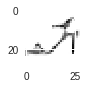

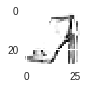

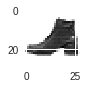

Epoch:  77
Disciminator cost:  0.0019710569130501777
Generator cost:  0.0018089141677133155


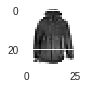

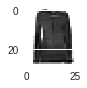

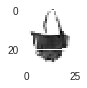

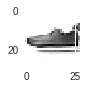

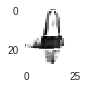

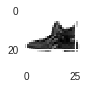

Epoch:  78
Disciminator cost:  0.0018676118952648327
Generator cost:  0.0013140236125982606


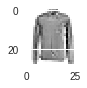

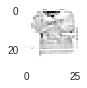

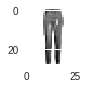

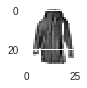

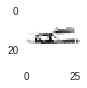

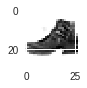

Epoch:  79
Disciminator cost:  0.0020443913750973677
Generator cost:  0.0014901990216553375


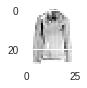

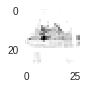

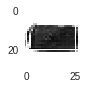

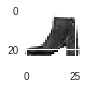

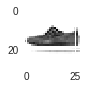

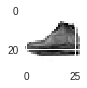

Epoch:  80
Disciminator cost:  0.00252830076444044
Generator cost:  0.0013176749684974066


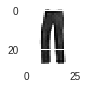

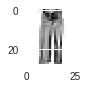

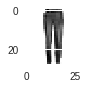

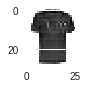

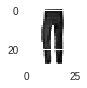

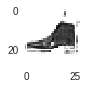

Epoch:  81
Disciminator cost:  0.001981064308163254
Generator cost:  0.0018081555557199309


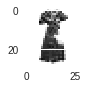

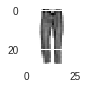

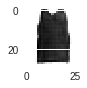

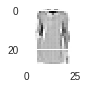

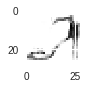

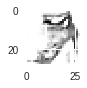

Epoch:  82
Disciminator cost:  0.0017439550949279767
Generator cost:  0.0016914405685941147


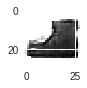

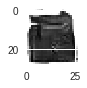

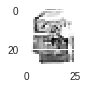

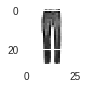

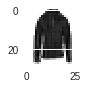

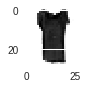

Epoch:  83
Disciminator cost:  0.0019818843910752826
Generator cost:  0.0014388301213997502


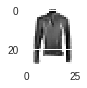

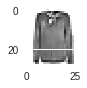

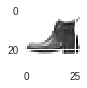

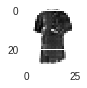

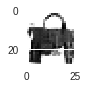

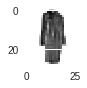

Epoch:  84
Disciminator cost:  0.0022771904170358877
Generator cost:  0.0012096420019997397


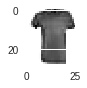

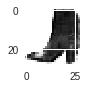

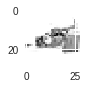

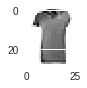

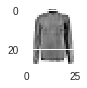

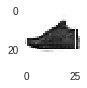

Epoch:  85
Disciminator cost:  0.002459939310566504
Generator cost:  0.0010168549775333153


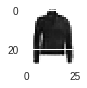

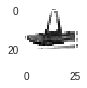

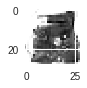

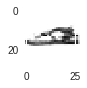

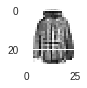

Epoch:  86
Disciminator cost:  0.0018716149929430327
Generator cost:  0.0015039133381331018


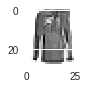

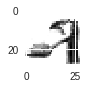

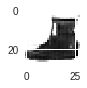

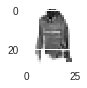

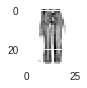

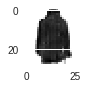

Epoch:  87
Disciminator cost:  0.0018739616367463023
Generator cost:  0.0015538163954594635


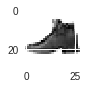

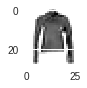

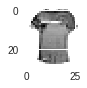

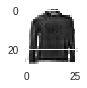

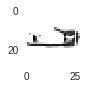

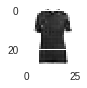

Epoch:  88
Disciminator cost:  0.0024918045341950864
Generator cost:  0.0014060364950075274


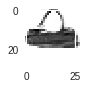

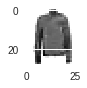

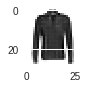

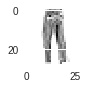

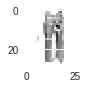

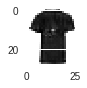

Epoch:  89
Disciminator cost:  0.002115376514713492
Generator cost:  0.0013064294102660356


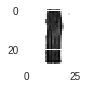

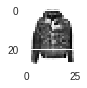

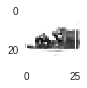

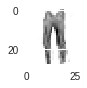

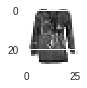

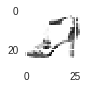

Epoch:  90
Disciminator cost:  0.002233526742159142
Generator cost:  0.001265332295652133


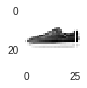

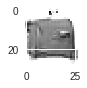

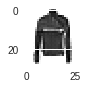

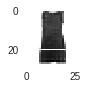

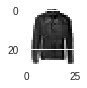

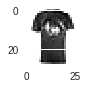

Epoch:  91
Disciminator cost:  0.0021808715649577295
Generator cost:  0.0011811890342626984


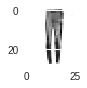

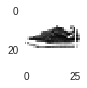

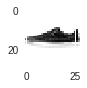

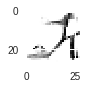

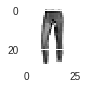

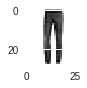

Epoch:  92
Disciminator cost:  0.0018220453733216698
Generator cost:  0.0013159946935752094


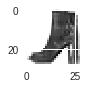

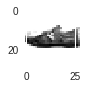

In [0]:
def train(no_epochs, glr, dlr):
    for epoch in range(no_epochs): #for each epoch, we need to sample from training set & generate samples 
        epochdcost = 0
        epochgcost = 0

        #generator maximize the cost of the discriminator
        #discriminator minimize its cost 
        #iteratre over mini-batches
        for k, (real_images, _ ) in enumerate(train_samples):
            real_images = Variable(real_images).cuda() #real images from training set

            z = Variable(torch.randn(batch_size, 128)).cuda() #generate random latent variable to generate images
            generated_images = g.forward(z).cuda() #generate images

            gen_pred = d.forward(generated_images) #prediction of generator on generated batch--> discriminator should predict 0 for all of this
            real_pred = d.forward(real_images) #prediction of generator on real batch --> discriminator should predict 1 for all of this

            dcost = -torch.sum(torch.log(real_pred) + torch.log(1-gen_pred))/batch_size #cost of discriminator
            #predicting the real 
            #graph: -log(x) fct 
            #if it predicts 1, there will be no addition to the cost 
            #if predict 0: will add to cost 
            
            #graph: y = -log(1-x) 
            #for generated images: if predict 0, then there will be no cost 
            # if predict 1 --> infinity 
            
            #take cross entropy loss wrt to each 
                 
            gcost = -torch.sum(torch.log(gen_pred))/batch_size #cost of generator
            #gen_pred: probability the generator image is real 
            
            #need to be sequential 
            
            #train discriminator
            d_optimizer.zero_grad()
            dcost.backward(retain_graph=True) #retain the computation graph so we can train generator after
            #need pytorch to keep graph for discriminator + generator 
            d_optimizer.step()
            
            #train generator
            g_optimizer.zero_grad()
            gcost.backward()
            g_optimizer.step()

            #calculate cost in batches & add cost to whole epoch 
            epochdcost += dcost.data[0]
            epochgcost += gcost.data[0]
            
            #give us an example of a generated image after every 10000 images produced
            #show how good it's gotted after 10K images 
            #k = total number of batches 
            # % = remainder of it when divided by 10K --> the remainder will only be 0 when it's 10K 
            
            if k*batch_size%10000 ==0:
                g.eval() #put in evaluation mode
                noise_input = Variable(torch.randn(1, 128)).cuda()
                generated_image = g.forward(noise_input)
                
                #prevent image distorsion: 
                plt.figure(figsize=(1, 1))
                #get first layer 
                plt.imshow(generated_image.data[0][0], cmap='gray_r')
                plt.show()
                g.train() #put back into training mode


            epochdcost /= 60000/batch_size # avg cost per batch 
            epochgcost /= 60000/batch_size

        print('Epoch: ', epoch)
        print('Disciminator cost: ', epochdcost)
        print('Generator cost: ', epochgcost)
        
        #plot costs: costs show show arms race 
        
        dcosts.append(epochdcost)
        gcosts.append(epochgcost)

        ax.plot(dcosts, 'b')
        ax.plot(gcosts, 'r')

        fig.canvas.draw()
        
    plt.figure()
    plt.plot(dcosts, 'b')
    plt.plot(gcosts,' r')
    plt.show()

train(no_epochs, glr, dlr)

#use colab GPU: runtime --> GPU --> run everything (install GPU version of torch)  
#there are more images in pytorch vision 